# 05. Publisher Analysis

This notebook performs a deep dive into publisher characteristics and patterns.

**Sections:**
1. **Top Contributing Publishers** - Publisher statistics, rankings, articles per day analysis, and coverage diversity
2. **News Type Differences by Publisher** - Event distribution by publisher and publisher specialization analysis
3. **Email Domain Analysis** - Domain extraction and analysis, organizational patterns

**Dependencies:** 
- Run `01_Data_Loading_and_Setup.ipynb` first to create processed data
- Run `03_Text_Analysis.ipynb` to create event detection columns (optional, but recommended)


In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re
from collections import Counter
from urllib.parse import urlparse
import warnings
warnings.filterwarnings('ignore')

# Add utils to path
sys.path.append('.')
from utils import setup_plotting_style, load_processed_data

# Setup plotting style
setup_plotting_style()

print("Libraries imported successfully!")


Plotting style configured
Libraries imported successfully!


In [10]:
# Ensure figures directory exists
figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Created {figures_dir}/ directory")
else:
    print(f"Using existing {figures_dir}/ directory")


Using existing figures/ directory


In [11]:
# Load processed data (if available) or load raw data
try:
    df = load_processed_data('../data/processed/df_processed.pkl')
    print(f"Loaded processed data: {df.shape}")
except FileNotFoundError:
    print("Processed data not found. Loading raw data...")
    from utils import load_data, preprocess_data, clean_data
    df = load_data('../data/raw_analyst_ratings.csv')
    df = clean_data(df, remove_duplicates=True, handle_missing='report', fix_dates=True)
    df = preprocess_data(df)
    print(f"Loaded and preprocessed data: {df.shape}")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check if event detection columns exist (from 03_Text_Analysis.ipynb)
event_cols = [col for col in df.columns if col.startswith('event_')]
if event_cols:
    print(f"\nFound {len(event_cols)} event detection columns from text analysis")
    print(f"Event columns: {event_cols[:5]}..." if len(event_cols) > 5 else f"Event columns: {event_cols}")
else:
    print("\n⚠ No event detection columns found. Run 03_Text_Analysis.ipynb first for full analysis.")
    print("Continuing with basic publisher analysis...")


Loaded processed data from ../data/processed/df_processed.pkl
Shape: (1407328, 8)
Loaded processed data: (1407328, 8)

Dataset shape: (1407328, 8)
Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'headline_word_count']

⚠ No event detection columns found. Run 03_Text_Analysis.ipynb first for full analysis.
Continuing with basic publisher analysis...


## 4.1 Top Contributing Publishers

**Objective:** Analyze publisher statistics, rankings, articles per day, and coverage diversity.

**Key Questions:**
- Which publishers contribute the most articles?
- What is the average number of articles per day for top publishers?
- How diverse is the coverage (stocks covered) by each publisher?
- What is the distribution of publishers?


In [12]:
# Publisher statistics
print("="*80)
print("TOP CONTRIBUTING PUBLISHERS")
print("="*80)

# Basic publisher statistics
publisher_stats = df.groupby('publisher').agg({
    'headline': 'count',
    'stock': 'nunique',
    'date': ['min', 'max']
}).reset_index()

# Flatten column names
publisher_stats.columns = ['publisher', 'total_articles', 'unique_stocks', 'first_article', 'last_article']

# Calculate date range in days
publisher_stats['date_range_days'] = (pd.to_datetime(publisher_stats['last_article']) - 
                                      pd.to_datetime(publisher_stats['first_article'])).dt.days + 1

# Calculate articles per day
publisher_stats['articles_per_day'] = publisher_stats['total_articles'] / publisher_stats['date_range_days'].replace(0, 1)

# Sort by total articles
publisher_stats = publisher_stats.sort_values('total_articles', ascending=False).reset_index(drop=True)

print(f"\nTotal unique publishers: {len(publisher_stats):,}")
print(f"\nTop 20 Publishers by Article Count:")
print("-" * 80)
for idx, row in publisher_stats.head(20).iterrows():
    print(f"{idx+1:2d}. {row['publisher']:40s} | Articles: {row['total_articles']:>8,} | "
          f"Stocks: {int(row['unique_stocks']):>3d} | Articles/day: {row['articles_per_day']:>6.2f}")

# Summary statistics
print(f"\n" + "="*80)
print("PUBLISHER SUMMARY STATISTICS")
print("="*80)
print(f"Mean articles per publisher: {publisher_stats['total_articles'].mean():.1f}")
print(f"Median articles per publisher: {publisher_stats['total_articles'].median():.1f}")
print(f"Max articles per publisher: {publisher_stats['total_articles'].max():,}")
print(f"Mean unique stocks per publisher: {publisher_stats['unique_stocks'].mean():.1f}")
print(f"Median unique stocks per publisher: {publisher_stats['unique_stocks'].median():.1f}")
print(f"Max unique stocks per publisher: {int(publisher_stats['unique_stocks'].max())}")


TOP CONTRIBUTING PUBLISHERS

Total unique publishers: 1,034

Top 20 Publishers by Article Count:
--------------------------------------------------------------------------------
 1. Paul Quintaro                            | Articles:  228,373 | Stocks: 4703 | Articles/day:  88.79
 2. Lisa Levin                               | Articles:  186,979 | Stocks: 4640 | Articles/day:  56.78
 3. Benzinga Newsdesk                        | Articles:  150,484 | Stocks: 4049 | Articles/day: 103.78
 4. Charles Gross                            | Articles:   96,732 | Stocks: 4181 | Articles/day:  31.03
 5. Monica Gerson                            | Articles:   82,380 | Stocks: 4012 | Articles/day:  35.39
 6. Eddie Staley                             | Articles:   57,254 | Stocks: 4466 | Articles/day:  22.32
 7. Hal Lindon                               | Articles:   49,047 | Stocks: 4474 | Articles/day:  22.13
 8. ETF Professor                            | Articles:   28,489 | Stocks: 1891 | Articles/da

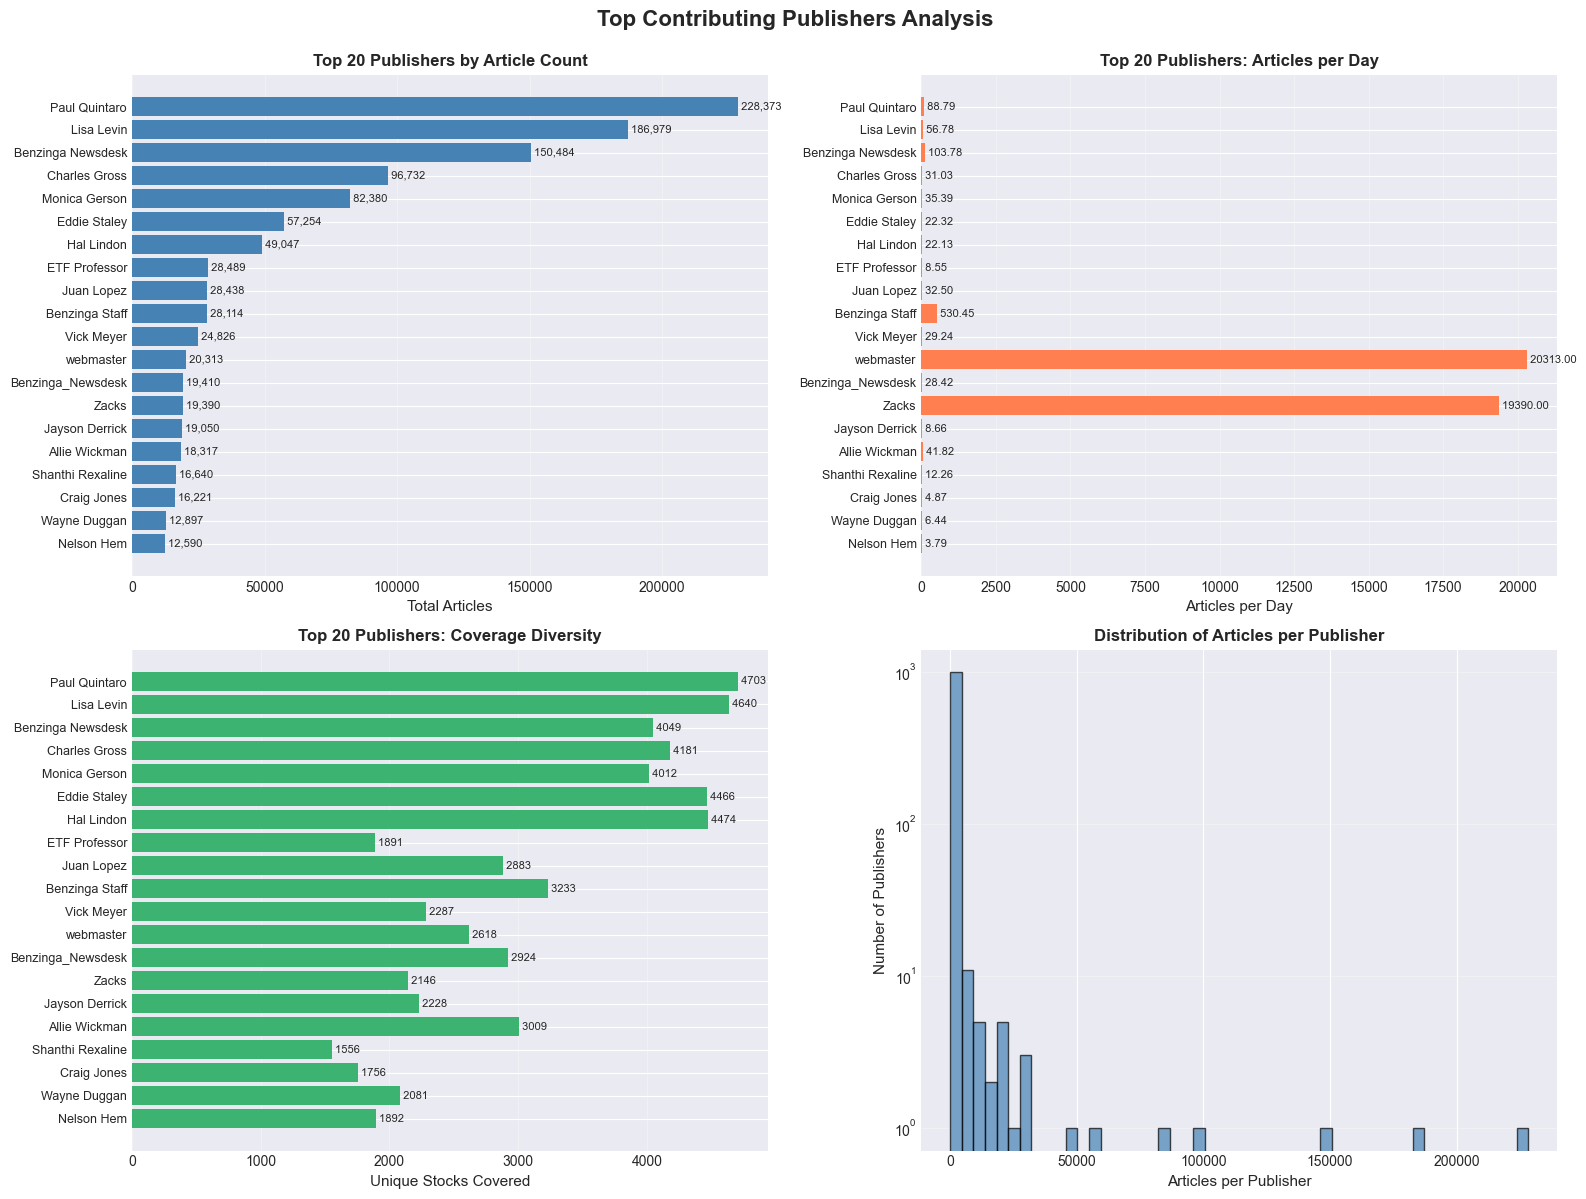

Saved: figures/top_publishers_analysis.png


In [13]:
# Visualize top publishers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Top Contributing Publishers Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Top 20 publishers by article count
ax1 = axes[0, 0]
top_20 = publisher_stats.head(20)
bars1 = ax1.barh(range(len(top_20)), top_20['total_articles'], color='steelblue')
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['publisher'], fontsize=9)
ax1.set_xlabel('Total Articles', fontsize=11)
ax1.set_title('Top 20 Publishers by Article Count', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax1.text(row['total_articles'], i, f" {int(row['total_articles']):,}",
            va='center', fontsize=8)

# Plot 2: Articles per day for top 20
ax2 = axes[0, 1]
bars2 = ax2.barh(range(len(top_20)), top_20['articles_per_day'], color='coral')
ax2.set_yticks(range(len(top_20)))
ax2.set_yticklabels(top_20['publisher'], fontsize=9)
ax2.set_xlabel('Articles per Day', fontsize=11)
ax2.set_title('Top 20 Publishers: Articles per Day', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax2.text(row['articles_per_day'], i, f" {row['articles_per_day']:.2f}",
            va='center', fontsize=8)

# Plot 3: Coverage diversity (unique stocks) for top 20
ax3 = axes[1, 0]
bars3 = ax3.barh(range(len(top_20)), top_20['unique_stocks'], color='mediumseagreen')
ax3.set_yticks(range(len(top_20)))
ax3.set_yticklabels(top_20['publisher'], fontsize=9)
ax3.set_xlabel('Unique Stocks Covered', fontsize=11)
ax3.set_title('Top 20 Publishers: Coverage Diversity', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax3.text(row['unique_stocks'], i, f" {int(row['unique_stocks'])}",
            va='center', fontsize=8)

# Plot 4: Distribution of articles per publisher (log scale)
ax4 = axes[1, 1]
ax4.hist(publisher_stats['total_articles'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax4.set_xlabel('Articles per Publisher', fontsize=11)
ax4.set_ylabel('Number of Publishers', fontsize=11)
ax4.set_title('Distribution of Articles per Publisher', fontsize=12, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/top_publishers_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: figures/top_publishers_analysis.png")


## 4.2 News Type Differences by Publisher

**Objective:** Analyze event distribution by publisher and identify publisher specialization.

**Key Questions:**
- Which publishers specialize in specific event types?
- How is event coverage distributed across publishers?
- Are there publishers that focus on particular types of financial news?


In [14]:
# Analyze event distribution by publisher
if event_cols:
    print("="*80)
    print("NEWS TYPE DIFFERENCES BY PUBLISHER")
    print("="*80)
    
    # Get event column names and their display names
    event_display_names = {}
    for col in event_cols:
        # Convert column name back to display name
        display_name = col.replace('event_', '').replace('_', ' ').title()
        event_display_names[col] = display_name
    
    # Calculate event counts by publisher
    publisher_event_counts = df.groupby('publisher')[event_cols].sum()
    
    # Calculate total articles per publisher
    publisher_totals = df.groupby('publisher').size()
    
    # Calculate event percentages by publisher
    publisher_event_pct = publisher_event_counts.div(publisher_totals, axis=0) * 100
    
    # Get top publishers
    top_publishers = publisher_totals.nlargest(15).index
    
    print(f"\nAnalyzing event distribution for top 15 publishers...")
    print(f"Total event types: {len(event_cols)}")
    
    # Find publishers with highest concentration of each event type
    print(f"\n" + "="*80)
    print("PUBLISHER SPECIALIZATION BY EVENT TYPE")
    print("="*80)
    for col in event_cols:
        display_name = event_display_names[col]
        top_pub = publisher_event_pct[col].nlargest(3)
        print(f"\n{display_name}:")
        for pub, pct in top_pub.items():
            total_events = publisher_event_counts.loc[pub, col]
            total_articles = publisher_totals[pub]
            print(f"  • {pub:40s}: {pct:5.2f}% ({int(total_events):,}/{int(total_articles):,} articles)")
    
else:
    print("="*80)
    print("NEWS TYPE DIFFERENCES BY PUBLISHER")
    print("="*80)
    print("\n⚠ Event detection columns not found.")
    print("Please run 03_Text_Analysis.ipynb first to enable this analysis.")
    print("Skipping event-based publisher analysis...")


NEWS TYPE DIFFERENCES BY PUBLISHER

⚠ Event detection columns not found.
Please run 03_Text_Analysis.ipynb first to enable this analysis.
Skipping event-based publisher analysis...


In [15]:
# Visualize event distribution by publisher
if event_cols and len(event_cols) > 0:
    # Create heatmap for top publishers and top events
    top_publishers = publisher_totals.nlargest(15).index
    top_events = publisher_event_counts.sum().nlargest(10).index
    
    # Get event display names for top events
    top_event_names = [event_display_names[col] for col in top_events]
    
    # Create heatmap data
    heatmap_data = publisher_event_pct.loc[top_publishers, top_events]
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', 
                cbar_kws={'label': 'Event Percentage (%)'}, ax=ax, linewidths=0.5)
    ax.set_xlabel('Event Type', fontsize=12)
    ax.set_ylabel('Publisher', fontsize=12)
    ax.set_title('Event Distribution by Publisher (Top 15 Publishers, Top 10 Events)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticklabels(top_event_names, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(top_publishers, rotation=0, fontsize=8)
    
    plt.tight_layout()
    plt.savefig('figures/publisher_event_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved: figures/publisher_event_distribution.png")
    
    # Create bar chart showing top event for each top publisher
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Get dominant event for each top publisher
    top_pub_dominant_events = []
    for pub in top_publishers[:15]:
        dominant_event_col = publisher_event_pct.loc[pub].idxmax()
        dominant_event_name = event_display_names[dominant_event_col]
        dominant_pct = publisher_event_pct.loc[pub, dominant_event_col]
        top_pub_dominant_events.append({
            'publisher': pub,
            'event': dominant_event_name,
            'percentage': dominant_pct
        })
    
    dominant_df = pd.DataFrame(top_pub_dominant_events)
    dominant_df = dominant_df.sort_values('percentage', ascending=True)
    
    # Create horizontal bar chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(dominant_df)))
    bars = ax.barh(range(len(dominant_df)), dominant_df['percentage'], color=colors)
    ax.set_yticks(range(len(dominant_df)))
    ax.set_yticklabels(dominant_df['publisher'], fontsize=9)
    ax.set_xlabel('Percentage of Articles with Dominant Event Type', fontsize=11)
    ax.set_title('Top Publishers: Dominant Event Type Specialization', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add event type labels
    for i, (idx, row) in enumerate(dominant_df.iterrows()):
        ax.text(row['percentage'], i, f" {row['event']} ({row['percentage']:.1f}%)",
               va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('figures/publisher_specialization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved: figures/publisher_specialization.png")


## 4.3 Email Domain Analysis

**Objective:** Extract and analyze email domains from publisher information to identify organizational patterns.

**Key Questions:**
- Can we extract email domains from publisher data?
- What are the most common email domains?
- Are there organizational patterns in publisher domains?


In [17]:
# Extract email domains from publisher column
print("="*80)
print("EMAIL DOMAIN ANALYSIS")
print("="*80)

# Check if publisher column contains email addresses
email_pattern = r'[\w\.-]+@[\w\.-]+\.\w+'
has_emails = df['publisher'].str.contains(email_pattern, na=False, regex=True).sum()

print(f"\nPublishers with email addresses: {has_emails:,} ({has_emails/len(df)*100:.2f}%)")

if has_emails > 0:
    # Extract email addresses (need capture group for str.extract)
    email_pattern_capture = r'([\w\.-]+@[\w\.-]+\.\w+)'
    df['email_extracted'] = df['publisher'].str.extract(email_pattern_capture)
    
    # Extract domains from emails
    df['email_domain'] = df['email_extracted'].str.split('@').str[1]
    
    # Also try to extract domains from URLs if available
    if 'url' in df.columns:
        df['url_domain'] = df['url'].apply(lambda x: urlparse(str(x)).netloc if pd.notna(x) else None)
    
    # Count domains
    email_domains = df[df['email_domain'].notna()]['email_domain'].value_counts()
    
    print(f"\nUnique email domains found: {len(email_domains):,}")
    print(f"\nTop 20 Email Domains:")
    print("-" * 80)
    for domain, count in email_domains.head(20).items():
        pct = count / len(df) * 100
        print(f"  {domain:40s}: {count:>8,} articles ({pct:>5.2f}%)")
    
    # Analyze domain patterns
    print(f"\n" + "="*80)
    print("DOMAIN PATTERN ANALYSIS")
    print("="*80)
    
    # Common domain extensions
    domain_extensions = df['email_domain'].str.split('.').str[-1].value_counts()
    print(f"\nTop Domain Extensions:")
    for ext, count in domain_extensions.head(10).items():
        print(f"  .{ext:10s}: {count:>8,} articles")
    
else:
    print("\n⚠ No email addresses found in publisher column.")
    print("Attempting to extract domains from URLs...")
    
    if 'url' in df.columns:
        # Extract domains from URLs
        df['url_domain'] = df['url'].apply(lambda x: urlparse(str(x)).netloc if pd.notna(x) else None)
        url_domains = df[df['url_domain'].notna()]['url_domain'].value_counts()
        
        print(f"\nUnique URL domains found: {len(url_domains):,}")
        print(f"\nTop 20 URL Domains:")
        print("-" * 80)
        for domain, count in url_domains.head(20).items():
            pct = count / len(df) * 100
            print(f"  {domain:40s}: {count:>8,} articles ({pct:>5.2f}%)")
        
        # Store for visualization
        email_domains = url_domains
    else:
        print("⚠ URL column not available. Skipping domain analysis.")
        email_domains = pd.Series()

        


EMAIL DOMAIN ANALYSIS

Publishers with email addresses: 8,088 (0.57%)

Unique email domains found: 8

Top 20 Email Domains:
--------------------------------------------------------------------------------
  benzinga.com                            :    7,937 articles ( 0.56%)
  gmail.com                               :      139 articles ( 0.01%)
  andyswan.com                            :        5 articles ( 0.00%)
  investdiva.com                          :        2 articles ( 0.00%)
  tothetick.com                           :        2 articles ( 0.00%)
  eosdetroit.io                           :        1 articles ( 0.00%)
  forextraininggroup.com                  :        1 articles ( 0.00%)
  stockmetrix.net                         :        1 articles ( 0.00%)

DOMAIN PATTERN ANALYSIS

Top Domain Extensions:
  .com       :    8,086 articles
  .io        :        1 articles
  .net       :        1 articles


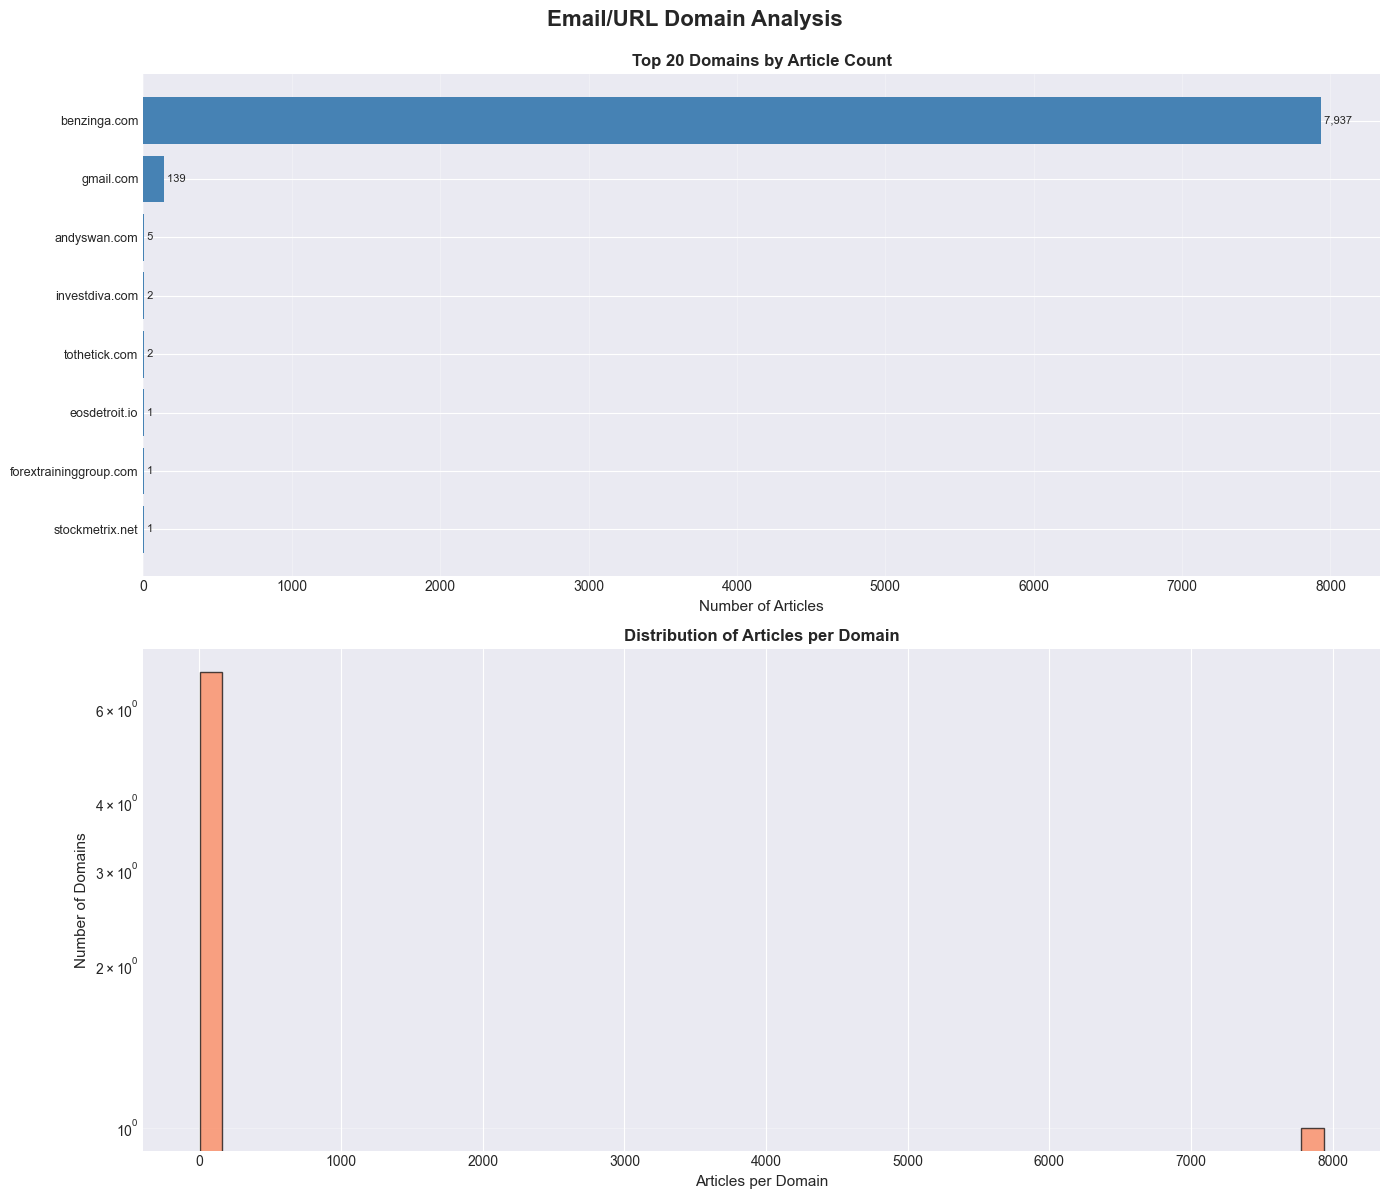

Saved: figures/domain_analysis.png


In [18]:
# Visualize domain analysis
if len(email_domains) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    fig.suptitle('Email/URL Domain Analysis', fontsize=16, fontweight='bold', y=0.995)
    
    # Plot 1: Top 20 domains
    ax1 = axes[0]
    top_20_domains = email_domains.head(20)
    bars = ax1.barh(range(len(top_20_domains)), top_20_domains.values, color='steelblue')
    ax1.set_yticks(range(len(top_20_domains)))
    ax1.set_yticklabels(top_20_domains.index, fontsize=9)
    ax1.set_xlabel('Number of Articles', fontsize=11)
    ax1.set_title('Top 20 Domains by Article Count', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.invert_yaxis()
    
    # Add value labels
    for i, count in enumerate(top_20_domains.values):
        ax1.text(count, i, f" {count:,}", va='center', fontsize=8)
    
    # Plot 2: Distribution of articles per domain (log scale)
    ax2 = axes[1]
    ax2.hist(email_domains.values, bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.set_xlabel('Articles per Domain', fontsize=11)
    ax2.set_ylabel('Number of Domains', fontsize=11)
    ax2.set_title('Distribution of Articles per Domain', fontsize=12, fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('figures/domain_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved: figures/domain_analysis.png")
else:
    print("\n⚠ No domain data available for visualization.")


## Summary and Key Findings

**Key Insights from Publisher Analysis:**

1. **Top Contributing Publishers:**
   - [To be filled after running the notebook]

2. **Publisher Specialization:**
   - [To be filled after running the notebook]

3. **Domain Patterns:**
   - [To be filled after running the notebook]

4. **Coverage Diversity:**
   - [To be filled after running the notebook]
